### Genetic image approximator

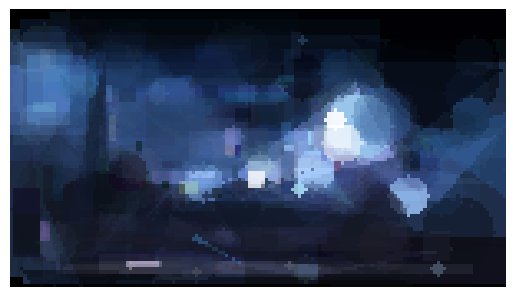

Figure 299, evolution stage 126, best score 0.7808625246929928. Figure area: 215.9999999999998


In [83]:
# CURRENT VERSION 6 (Optimization, image format support)

import random
import math as mt
import numpy as np
from PIL import Image
import matplotlib.image as image
from matplotlib import pyplot as plt
import copy
import operator
from IPython.display import clear_output
import _pickle as cPickle
import time
import cv2
import os

from PIL import Image

random.seed(30)
T = 3 # tolerance to accept small figures
L = 255 # max pixel value
eps = 0.1 # for compensating calc errors


alpha_v = (0.1, 0.5, 0.9)

aprx_path = "./Approximations/"
baprx_path = "./BestApproximations/"
tss_path = "./ToSlideShow/"

# (coordinates - [x,y])

class Point2D:
        
    def __init__(self,*,borders = [0, 0], coords = [-1, -1]):
        if coords != [-1, -1] and borders == [0, 0]:
            self.x = coords[0]
            self.y = coords[1]
            self.c = coords
        else:
            self.x = random.randint(0, borders[0]-1)
            self.y = random.randint(0, borders[1]-1)
            self.c = [self.x, self.y]
    
    def get_l(self):
        return mt.hypot(self.x, self.y)
        
    def sort(points):
        l_list = [p.get_l() for p in points]
        points = [Point2D(coords = coord[::-1]) for coord in sorted(zip([point.y for point in points], [point.x for point in points]))]
        return points
    
    def cross(self, point):
        self.x = int((self.x + point.x)/2)
        self.y = int((self.y + point.y)/2)
        self.c = [self.x, self.y]
        return self
    
    def mutate(self, borders, mut_power):
        self.x = int(max(min(self.x * (random.random()*(mut_power*2)+(1-mut_power)), borders[0]-1),0))
        self.y = int(max(min(self.y * (random.random()*(mut_power*2)+(1-mut_power)), borders[1]-1),0))
        return self
    
    def to_list(self):
        return [self.x, self.y]
    
    def get_diff(self, point):
        return mt.hypot(self.x - point.x, self.y - point.y) 
        

class Circle:
    
    def __init__(self, borders, limit):
        self.c = Point2D(borders = borders)
        # self.r = random.randint(0, int(max(borders[0], borders[1])/2))
        self.r = random.randint(0, np.min([abs(self.c.x-borders[0]+1), abs(self.c.y-borders[1]+1),max(self.c.x-1,0), max(self.c.y-1,0)]))
        if limit == 1:
            self.rgb = [random.random(), random.random(), random.random()]
        else:
            self.rgb = [random.randint(0, limit), random.randint(0, limit), random.randint(0, limit)]
        self.a = random.choice(alpha_v)
        # self.to_string()
    
    def to_string(self):
        print('I AM CIRCLE')
        print(f'radius {self.r}')
        print(f'center {self.c.x} {self.c.y}')
        print(f'a {self.a}')
        print(f'rgb {self.rgb}')
        
    def get_area(self):
        return 2*mt.pi*(self.r**2)
    
    def get_borders(self):
        h = 2 * self.r + 1
        w = 2 * self.r + 1
        return h,w
    
    def get_shift(self):
        return (max(self.c.y-self.r - 1, 0), max(self.c.x-self.r - 1,0))
     
    def draw_figure(self):
        h,w = self.get_borders()
        # A = np.arange(-self.c.y + 1,h - self.c.y + 1)**2
        # B = np.arange(-self.c.x + 1,w - self.c.x + 1)**2
        # A = np.arange(0,h)**2
        # B = np.arange(0,w)**2
        A = np.arange(- np.ceil(h/2) + 1,h - np.ceil(h/2) + 1)**2
        B = np.arange(- np.ceil(w/2) + 1,w - np.ceil(w/2) + 1)**2
        dists = np.sqrt(A[:,None] + B)
        matrix = (dists <= self.r).astype(np.uint8)
        matrix = np.array([matrix*self.rgb[0], matrix*self.rgb[1], matrix*self.rgb[2]])
        matrix = np.transpose(matrix, axes = (1,2,0))
        return matrix, self.get_shift()
    
    def check_belonging(self, point):
        if (mt.hypot(point.x - self.c.x, point.y - self.c.y) < self.r):
            return True
        else:
            return False
    
    def cross(self, fig, cross_power):
        if random.random() > 0.5:
            self.c.cross(fig.c)
            self.r = int((self.r + fig.r)/2)
            self.r = max(np.min([self.c.x-1, self.c.y-1, self.r]),0)
        else:
            self.rgb = [np.random.choice(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [np.mean(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [(x*(1-cross_power)+y*cross_power) for x,y in zip(self.rgb, fig.rgb)]
            # self.rgb = fig.rgb
            self.a = (fig.a + fig.a)/2
        return self
    
    def mutate(self, borders, mut_power):
        if random.random() > 0.5:
            self.r = int(min(self.r * (random.random()*(mut_power*2)+(1-mut_power)), min((borders[1]-1)/2,(borders[0]-1)/2)))
            self.c = self.c.mutate(borders, mut_power)
            self.c = Point2D(borders = [0,0], coords = [max(min(self.c.x,borders[0]-self.r-1), self.r+1), max(min(self.c.y,borders[1]-self.r-1), self.r+1)])
        else:
            self.rgb = [int(max(min(elem*(random.random()*(mut_power*2)+(1-mut_power)),L),0)) for elem in self.rgb]
            self.a = random.choice(alpha_v)
        return self
    
class Triangle:
    
    def __init__(self, borders, limit):
        self.v_list = [Point2D(borders = borders), Point2D(borders = borders), Point2D(borders = borders)]
        if limit == 1:
            self.rgb = [random.random(), random.random(), random.random()]
        else:
            self.rgb = [random.randint(0, limit), random.randint(0, limit), random.randint(0, limit)]
        self.a = random.choice(alpha_v)
        self.c = Point2D(coords = [np.mean(np.array(k)) for k in zip(self.v_list[0].c, self.v_list[1].c, self.v_list[2].c)])
        # self.to_string()
    
    def to_string(self):
        print('I AM TRIANGLE')
        print([[vertex.x, vertex.y] for vertex in self.v_list])
        print(f'a {self.a}')
        print(f'rgb {self.rgb}')
        
    def get_area(self):
        side_ls = [((p1.x-p2.x)**2+(p1.y-p2.y)**2)**0.5 for p1, p2 in zip(self.v_list, self.v_list[1:]+self.v_list[:1])]
        hp = sum(side_ls)/2
        self.area = (hp*np.prod([hp-ls for ls in side_ls]))**0.5
        return self.area
    
    def get_borders(self):
        h = max([point.y for point in self.v_list])-min([point.y for point in self.v_list]) + 1
        w = max([point.x for point in self.v_list])-min([point.x for point in self.v_list]) + 1
        return h,w
    
    def get_shift(self):
        return (min([point.y for point in self.v_list]),min([point.x for point in self.v_list]))
    
    def draw_figure(self):
        h,w = self.get_borders()
        shift = self.get_shift()
        points = [np.subtract(point.to_list(), shift[::-1]) for point in self.v_list]
        matrix = np.ones((h,w), dtype = bool)
        for p1, p2, p3 in zip(points, points[1:]+points[:1], points[2:]+points[:2]):
            delta = np.subtract(p1,p2)
            delta[1] = -delta[1]
            A = delta[0]*np.arange(0,h)
            B = delta[1]*np.arange(0,w)
            b = np.dot(delta[::-1], p1)
            if (delta[0]*p3[1]+delta[1]*p3[0] - b) >= 0:
                dists = (((A[:,None] + B) - b) >= 0)
            else:
                dists = (((A[:,None] + B) - b) <= 0)
            matrix = np.logical_and(matrix, dists)
        matrix = matrix.astype(np.uint8)
       
        matrix = np.array([matrix*self.rgb[0], matrix*self.rgb[1], matrix*self.rgb[2]])
        matrix = np.transpose(matrix, axes = (1,2,0))
        return matrix, shift
    
    def cross(self, fig, cross_power):
        if random.random() > 0.5:
            for v in self.v_list:
                v.cross(fig.v_list[np.argmin([v.get_diff(v2) for v2 in fig.v_list])])
            self.c = Point2D(coords = [np.mean(k) for k in zip(self.v_list[0].c, self.v_list[1].c, self.v_list[2].c)])
            # self.v_list[0].cross(trian.v_list[0])
            # self.v_list[1].cross(trian.v_list[1])
            # self.v_list[2].cross(trian.v_list[2])
        else:
            self.rgb = [np.random.choice(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [np.mean(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [(x*(1-cross_power)+y*cross_power) for x,y in zip(self.rgb, fig.rgb)]
            # self.rgb = fig.rgb
            # self.a = (self.a + trian.a)/2
            
            # self.rgb = trian.rgb
            self.a = fig.a
            
        return self

#     def cross(self, trian):
#         if random.random() > 0.5:
#             # for v in self.v_list:
#                 # v.cross(trian.v_list[np.argmin([v.get_diff(v2) for v2 in trian.v_list])])
#             self.v_list = trian.v_list
#         else:
#             self.rgb = trian.rgb
#             self.a = trian.a

#         return self
    
    def mutate(self, borders, mut_power):
        if random.random() > 0.5:
            vertex1 = self.v_list[0].mutate(borders, mut_power)
            vertex2 = self.v_list[1].mutate(borders, mut_power)
            vertex3 = self.v_list[2].mutate(borders, mut_power)
            self.v_list = Point2D.sort([vertex1, vertex2, vertex3])
            self.c = Point2D(coords = [np.mean(k) for k in zip(self.v_list[0].c, self.v_list[1].c, self.v_list[2].c)])
        #[min(elem*(random.random()*(mut_power*2)+(1-mut_power)),L) for elem in self.rgb]
        else: 
            self.rgb = [int(max(min(elem*(random.random()*(mut_power*2)+(1-mut_power)),L),0)) for elem in self.rgb]
            self.a = random.choice(alpha_v)
        return self

        
class Rectangle:
        
    def __init__(self, borders, limit):
        vertex1 = Point2D(borders = borders)
        vertex2 = Point2D(borders = borders)
        
        self.v_list = [Point2D(coords = [min(vertex1.x, vertex2.x), min(vertex1.y, vertex2.y)]),
                       Point2D(coords = [max(vertex1.x, vertex2.x), max(vertex1.y, vertex2.y)])]
        if limit == 1:
            self.rgb = [random.random(), random.random(), random.random()]
        else:
            self.rgb = [random.randint(0, limit), random.randint(0, limit), random.randint(0, limit)]
        self.a = random.choice(alpha_v)
        self.c = Point2D(coords = [np.mean(k) for k in zip(self.v_list[0].c, self.v_list[1].c)])
        # self.to_string()
        
    def to_string(self):
        print('I AM RECTANGLE')
        print ([[vertex.x, vertex.y] for vertex in self.v_list])
        print(f'a {self.a}')
        print(f'rgb {self.rgb}')
    
    def get_area(self):
        return (self.v_list[1].x - self.v_list[0].x) * (self.v_list[1].y - self.v_list[0].y)
        
    def get_borders(self):
        h = self.v_list[1].y - self.v_list[0].y + 1
        w = self.v_list[1].x - self.v_list[0].x + 1
        return h,w
    
    def get_shift(self):
        return (self.v_list[0].y, self.v_list[0].x)

    def draw_figure(self):
        h,w = self.get_borders()
        # print(h,w)
        # print(h,w)
        matrix = np.array([np.full((h,w), fill_value=self.rgb[0]),np.full((h,w), fill_value=self.rgb[1]), np.full((h,w), fill_value=self.rgb[2])])
        matrix = np.transpose(matrix, axes = (1,2,0))
        
        return matrix, self.get_shift()
    
    def check_belonging(self, point):
        if (point.x > self.v_list[0].x and point.x < self.v_list[1].x and
            point.y > self.v_list[0].y and point.y < self.v_list[1].y): 
            return True
        else:
            return False
        
    def cross(self, fig, cross_power):
        if random.random() > 0.5:
            # self.v_list[0].cross(fig.v_list[0])
            # self.v_list[1].cross(fig.v_list[1])
            # self.v_list = [Point2D(coords = [min(self.v_list.x, vertex2.x), min(vertex1.y, vertex2.y)]),
            #                Point2D(coords = [max(vertex1.x, vertex2.x), max(vertex1.y, vertex2.y)])]
            
            vertex1 = self.v_list[0].cross(fig.v_list[0])
            vertex2 = self.v_list[1].cross(fig.v_list[0])
            self.v_list = [Point2D(coords = [min(vertex1.x, vertex2.x), min(vertex1.y, vertex2.y)]),
                           Point2D(coords = [max(vertex1.x, vertex2.x), max(vertex1.y, vertex2.y)])]
            
            self.c = Point2D(coords = [np.mean(k) for k in zip(self.v_list[0].c, self.v_list[1].c)])
        else:
            self.rgb = [np.random.choice(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [np.mean(k) for k in zip(self.rgb, fig.rgb)]
            # self.rgb = [(x*(1-cross_power)+y*cross_power) for x,y in zip(self.rgb, fig.rgb)]
            # self.rgb = fig.rgb
            self.a = (self.a+fig.a)/2
        return self
        
    def mutate(self, borders, mut_power):
        if random.random() > 0.5:
            vertex1 = self.v_list[0].mutate(borders, mut_power)
            vertex2 = self.v_list[1].mutate(borders, mut_power)
            self.v_list = [Point2D(coords = [min(vertex1.x, vertex2.x), min(vertex1.y, vertex2.y)]),
                           Point2D(coords = [max(vertex1.x, vertex2.x), max(vertex1.y, vertex2.y)])]
            
            # print(self.v_list[0].x, self.v_list[1].x, self.v_list[0].y, self.v_list[1].y)
            
            # self.rgb = [min(elem*(random.random()*(mut_power*2)+(1-mut_power)),255) for elem in self.rgb]
            self.c = Point2D(coords = [np.mean(k) for k in zip(self.v_list[0].c, self.v_list[1].c)])
        else:
            self.rgb = [int(max(min(elem*(random.random()*(mut_power*2)+(1-mut_power)),L),0)) for elem in self.rgb]
            self.a = random.choice(alpha_v)
        return self
        #self.to_string()
        
    
class Approximation:
                
    def __init__(self, borders, min_area, limit):
        self.figure = None
        self.borders = borders
        self.lim = limit
        # self.buf_image = [[[] for j in range(self.borders[0])] for i in range(self.borders[1])]
        self.min_area = min_area
        self.matrix = None
        self.error_matrix = None
        
    def random_figure(self, fig_type, tolerance=T):
        i=0
        area = 0
        while area < self.min_area and i < tolerance:
            if fig_type == 'c':
                self.figure = Circle(self.borders, self.lim)
            if fig_type == 't':
                self.figure = Triangle(self.borders, self.lim)
            if fig_type == 'r':
                self.figure = Rectangle(self.borders, self.lim)
            area = self.figure.get_area()
            i+=1
            # print(area, self.borders[0]*self.borders[1]/32)
    
    def set_figure(self, figure):
        self.figure = figure
            
    # def delete_last_figure(self):
    #     return self.f_list.pop()
        
    def generate_image(self, base_image):
        self.matrix = cPickle.loads(cPickle.dumps(base_image, -1))
        if self.figure.get_area() > 0:
            fm, shift = self.figure.draw_figure()
            amat = (fm>0)*self.figure.a
            amat[self.matrix[shift[0]:shift[0]+len(fm), shift[1]:shift[1]+len(fm[0]), :]==0] = 1 
            self.matrix[shift[0]:shift[0]+len(fm), 
                        shift[1]:shift[1]+len(fm[0]), :] = self.matrix[shift[0]:shift[0]+len(fm), 
                                                                       shift[1]:shift[1]+len(fm[0]), :] * (1-amat) + fm * amat
        return self.matrix.astype(np.uint8)
                
        
    def get_matrix(self):                 
        return self.matrix
    
    def get_error_matrix(self):
        return self.error_matrix
    
    def calculate_error(self, image_matrix, type_of_error):
        # self.error_matrix = np.zeros((self.borders[1], self.borders[0], 3))
        # self.error_matrix = image_matrix - self.matrix
        # self.error_matrix[self.error_matrix < 0] = self.error_matrix[self.error_matrix < 0]**4
        self.error_matrix = np.absolute(image_matrix - self.matrix)
        if type_of_error == "SSD":
            self.error = np.sum(self.error_matrix**2)
        if type_of_error == "SAD":
            self.error = np.sum(self.error_matrix)
        # self.error_matrix = (self.error_matrix-np.min(self.error_matrix))/(np.max(self.error_matrix)-np.min(self.error_matrix))*self.lim
        return self.error, self.error_matrix
    
    
    def cross(self, base_image, aprx, cross_power):
        a = cPickle.loads(cPickle.dumps(self, -1))
        a.figure.cross(aprx.figure, cross_power)
        # a.generate_image(base_image)
        return a
    
    def mutate(self, base_image, mut_power, tolerance=T):
        a = cPickle.loads(cPickle.dumps(self, -1))
        
        #a.f_list[iteration] = a.f_list[iteration].cross(type(a.f_list[iteration])(self.border, self.lim))
        area = 0;
        i=0;
        while area < self.min_area and i < tolerance:
            last_figure = copy.deepcopy(a.figure).mutate(self.borders, mut_power)
            area = last_figure.get_area() 
            i+=1;
           
        a.figure = last_figure
        # print(a.figure.v_list[0].x, a.figure.v_list[1].x, a.figure.v_list[0].y, a.figure.v_list[1].y)
        # a.generate_image(base_image)
        return a
        
                    
        
class GeneticAlgorithm:
    def __init__(self, img, n_generations, n_entities, n_figures, name):
        self.borders = [img.shape[1], img.shape[0]]
        self.lim = L
        self.n_entities = n_entities
        self.n_generations = n_generations
        self.n_figures = n_figures
        self.img = img
        self.entities = []
        self.min_area = self.borders[0]*self.borders[1]/64
        for i in range(n_entities):
            self.entities.append(Approximation(self.borders, self.min_area, self.lim))
        self.name = name

        self.f_list = []
        self.matrix = np.zeros((self.borders[1], self.borders[0], 3)).astype(np.uint8) # all the approximations are based here
        
    def update_buf(self):
        figure = self.entities[0].figure
        self.f_list.append(figure)
        fm, shift = figure.draw_figure()
        amat = (fm>0)*figure.a
        amat[self.matrix[shift[0]:shift[0]+len(fm), shift[1]:shift[1]+len(fm[0]), :]==0] = 1 
        self.matrix[shift[0]:shift[0]+len(fm), 
                    shift[1]:shift[1]+len(fm[0]), :] = self.matrix[shift[0]:shift[0]+len(fm), 
                                                                   shift[1]:shift[1]+len(fm[0]), :] * (1-amat) + fm * amat
        self.matrix = self.matrix.astype(np.uint8)
        
    def evolution(self, n_selections, cross_prob, cross_power, mut_prob, mut_power, selection_type, elitism_num):
        si = np.sum(self.img)
        min_score = si
        
        _types = ('c', 't', 'r')
        fig_types = []
        n_fig_left = copy.deepcopy(self.n_figures)
        for i in range(self.n_figures[0] + self.n_figures[1] + self.n_figures[2]):
            fig_types = [_types[i] for i in range(len(_types)) if n_fig_left[i] > 0]
            scores = {}
            best_score = [si, 'c']
            # print(fig_types)
            # print(n_fig_left)
            for fig_type in fig_types:
                for k in range(self.n_entities):
                    self.entities[k].random_figure(fig_type)
                    self.entities[k].generate_image(self.matrix)
                j = 0
                self.fitness()
                while j < self.n_generations/8:
                    self.selection(n_selections, selection_type, elitism_num)
                    self.crossingover(cross_prob, cross_power)
                    self.mutation(mut_prob, elitism_num, mut_power)
                    self.fitness()
                    j += 1
                    # clear_output(wait=True)
                    # self.visualize_all()
                    # self.visualize(False)
                # self.visualize_all()
                scores[fig_type] = self.errors[0]  
                if best_score[0] > scores[fig_type]:
                    best_score = [scores[fig_type], fig_type]
                    temp_list = []
                    for k in range(self.n_entities):
                        temp_list.append(cPickle.loads(cPickle.dumps(self.entities[k].figure, -1)))
                    
                    # best_list = cPickle.loads(cPickle.dumps(temp_list, -1)) # new
            # print(f'Best score ({best_score[0]}) was achieved with {best_score[1]}')
            # print(scores)
            # time.sleep(5)
            for k in range(self.n_entities):
                self.entities[k].set_figure(temp_list[k]) # TODO
                # self.entities[k].generate_image(self.matrix)

            unchanged_c = 0
            j = 0
            self.fitness()
            temp = self.errors[0]
            while (j < self.n_generations or self.errors[0] > min_score) and unchanged_c < self.n_generations/4:
                
                self.selection(n_selections, selection_type, elitism_num)
                #print('sel', len(self.entities))
                self.crossingover(cross_prob, cross_power)
                #print('cross', len(self.entities))
                #print('mut', len(self.entities))
                self.mutation(mut_prob, elitism_num, mut_power)
                self.fitness()
                if abs(temp-self.errors[0]) < eps:
                    unchanged_c += 1
                else:
                    unchanged_c = 0
                temp = self.errors[0]
                j += 1
                self.metrics = (si-self.errors[0])/si
                area = self.entities[0].figure.get_area()
                title = f"Figure {i}, evolution stage {j}, best score {self.metrics}. Figure area: {area}"
                # self.visualize(title)
                
                self.visualize(title)
                # print(n_fig_left)
                
            if min_score <= self.errors[0]+eps:
                i-=1
                continue
                
            n_fig_left[_types.index(best_score[1])] -= 1
            min_score = self.errors[0]
            self.update_buf()
            self.visualize(title, True)
            # print(f"Evolution stage {j} of iteration {i}, best score {(si-self.errors[0])/si}, Area: {self.entities[0].f_list[-1].get_area()}")
            
        # self.fig_prune()
        self.visualize_final(title)
        # print(min_score)
        # print(self.errors)
        # print(self.to_keep)
        # self.show_removed()
            
    def fitness(self):
        self.errors = []
        for i in range(len(self.entities)):
            self.entities[i].generate_image(self.matrix)
            self.errors.append(self.entities[i].calculate_error(self.img, 'SAD')[0])
        return self.errors[0]
    
    def selection(self, n_selections, selection_type, elitism_num):
        self.errors, self.entities =  zip(*sorted(zip(self.errors, self.entities), key=operator.itemgetter(0)))
        self.entities = list(self.entities)
        #print(self.errors[0:10])
        temp_list = []
        if selection_type == 'roulette':
            probabilities = [((max(self.errors) + eps - err) / ((max(self.errors) + eps) * len(self.errors) - sum(self.errors))) for err in self.errors]
            include_list = np.zeros(len(self.entities))
            while len(temp_list) < n_selections:
                rnd = random.random()
                j = -1
                temp_p = 0
                while temp_p <= rnd:
                    temp_p += probabilities[j]
                    j += 1
                if include_list[j] == 0:
                    temp_list.append(self.entities[j])
                    include_list[j] = 1
                    #print(include_list)
                    
        elif selection_type == 'tournament':
            while len(temp_list) < n_selections:
                rnd_list = random.sample(self.errors, 2)
                temp_list.append(cPickle.loads(cPickle.dumps(self.entities[self.errors.index(min(rnd_list))], -1)))
        # self.entities[(n_selections+elitism_num):] = []
        self.entities[elitism_num:] = temp_list # (n_selections+elitism_num)


    def crossingover(self, cross_prob, cross_power, tolerance=T):
        temp_list = []
        # while len(temp_list) < self.n_entities:
        #     A, B = random.sample(range(0, len(self.entities)), 2)
        #     temp_list.append(self.entities[A].cross(self.entities[B], cross_prob))
        # self.entities = temp_list
        # areas = [entity.f_list[-1].get_area() for entity in self.entities]
        # if np.max(areas) < self.entities[0].min_area:
        #     while len(self.entities) < self.n_entities:
        #         self.entities.append(copy.copy(self.entities[0]))
        #     return 0
        
        while len(self.entities) < self.n_entities:
            for i in range(tolerance):
                A, B = random.sample(range(0, len(self.entities)), 2)
                C = self.entities[A].cross(self.matrix, self.entities[B], cross_power)
                if C.figure.get_area() > self.entities[A].min_area:
                    break
            self.entities.append(C)
        return 1

    def mutation(self, prob, elitism_num, mut_power):
        # self.errors, self.entities =  zip(*sorted(zip(self.errors, self.entities), key=operator.itemgetter(0)))
        # self.entities = list(self.entities)
        for i in range(elitism_num, len(self.entities)): # elitism_num
            #if random.random() < prob**(0.2)*(i)/(self.n_entities-1):
            if random.random() < prob:
                #print(i)
                self.entities[i] = self.entities[i].mutate(self.matrix, mut_power)

                
    def visualize(self, title, save=False):
        matrix = self.entities[0].get_matrix()
        # print(np.max(matrix), np.min(matrix))
        plt.imshow(matrix) 
        plt.axis('off')
        if save:
            plt.savefig(f"{aprx_path}{self.name}_{self.metrics:.5f}.png", transparent=True, bbox_inches='tight', pad_inches=0)
            plt.savefig(f"{tss_path}{self.name}_{self.metrics:.5f}.png", transparent=True, bbox_inches='tight', pad_inches=0)
        # plt.figure(figsize=(12,4), dpi = 80)
        # plt.subplot(1,3,1)
        # plt.imshow(matrix)
        # plt.axis('off')
        # plt.subplot(1,3,2)
        # plt.imshow(self.entities[0].get_error_matrix())
        # plt.axis('off')
        # plt.subplot(1,3,3)
        # plt.imshow(self.entities[0].get_error_matrix()+matrix)
        # plt.axis('off')
        # plt.savefig(name+' '+str(int(self.errors[0])))
        clear_output(wait=True)
        plt.show()
        # plt.draw_idle()
        print(title, flush=True)

    def visualize_final(self, title):
        clear_output(wait=True)
        
        plt.imshow(self.matrix)
        plt.axis('off')
        plt.savefig(f"{baprx_path}{self.name}_{self.metrics:.5f}.png", transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()
        print(title, flush=True)
        # time.sleep(0.01)
            
    def visualize_all(self):
        clear_output(wait=True)
        grid_size = int(self.n_entities**0.5)
        figure, axis = plt.subplots(grid_size, grid_size, figsize=(5, 5), gridspec_kw = {'wspace':0.05, 'hspace':0.05})
        for i, entity in enumerate(self.entities):
            axis[i//grid_size, i%grid_size].imshow(entity.get_matrix())
            axis[i//grid_size, i%grid_size].axis('off')
        # plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()
        
            

    def list_mutation(self, tlist, mut_power):
        tlist = [elem*(random.random()*(mut_power*2)+(1-mut_power)) for elem in tlist]
        return tlist
    
    def delete_duplicates(self):
        self.entities = list(dict(zip(self.errors, self.entities)).values())
        #print(self.entities)
        
    def get_best(self):
        return self.entities[0]

    def generate_image_fs(self, f_list):
        matrix = np.zeros((self.borders[1], self.borders[0], 3)).astype(np.uint8)
        for fig in f_list:
            fm, shift = fig.draw_figure()
            amat = (fm>0)*fig.a
            amat[matrix[shift[0]:shift[0]+len(fm), shift[1]:shift[1]+len(fm[0]), :]==0] = 1 
            matrix[shift[0]:shift[0]+len(fm), shift[1]:shift[1]+len(fm[0]), :] = matrix[shift[0]:shift[0]+len(fm), shift[1]:shift[1]+len(fm[0]), :] * (1-amat) + fm * amat
        return matrix

    
    def calculate_error(self, type_of_error):
        # self.error_matrix = np.zeros((self.borders[1], self.borders[0], 3))
        # self.error_matrix = self.img - self.matrix
        # self.error_matrix[self.error_matrix < 0] = self.error_matrix[self.error_matrix < 0]**4
        self.error_matrix = np.absolute(self.img - self.matrix)
        if type_of_error == "SSD":
            self.error = np.sum(self.error_matrix**2)
        if type_of_error == "SAD":
            self.error = np.sum(self.error_matrix)
        # self.error_matrix = (self.error_matrix-np.min(self.error_matrix))/(np.max(self.error_matrix)-np.min(self.error_matrix))*self.lim
        return self.error, self.error_matrix
        
    def fig_prune(self):
        gen_error, gen_err_matrix = self.calculate_error("SAD")
        self.to_keep = np.ones(len(self.f_list)).astype(bool)
        self.errors = []
        ratios = []
        error_matrices = [gen_err_matrix]
        for i in range(len(self.f_list)):
            self.matrix = self.generate_image_fs(self.f_list[:i]+self.f_list[i+1:])
            error, error_matrix = self.calculate_error("SAD")
            self.errors.append(error)
            ratios.append(int(((error/gen_error)*1000))/1000)
            error_matrices.append(error_matrix)
            if ratios[-1] <= 1:
                self.to_keep[i] = 0
        # print(errors)
        # print(to_keep)
        self.removed_f = (np.array(self.f_list)[np.logical_not(self.to_keep)]).tolist()
        self.f_list = (np.array(self.f_list)[self.to_keep]).tolist()
        self.matrix = self.generate_image_fs(self.f_list)
        return self.errors, self.to_keep, error_matrices, gen_error

    def show_removed(self):
        aprx = Approximation(self.borders, self.min_area, self.lim)
        temp_matrix = np.zeros((self.borders[1], self.borders[0], 3)).astype(np.uint8)
        for figure in self.removed_f:
            aprx.set_figure(figure)
            m = aprx.generate_image(temp_matrix)
            plt.imshow(m)
            plt.axis('off')
            plt.show()

def setup_env():
    if not os.path.exists(aprx_path):
        os.makedirs(aprx_path)

    if not os.path.exists(baprx_path):
        os.makedirs(baprx_path)

    os.system(f'rm -rf {tss_path}')   
    os.makedirs(tss_path)


# All the parameters to change

image_path = "Resources/irithyl.jpg" # path to an image to approximate

A = 150 # output resolution 

n_generations = 150 # how long to optimize each figure
n_entities = 64 # population
n_figures = [100,100,100] # how much figures to use for an approximation

n_selections = n_entities//16 # 8, 16
cross_prob = 1 # 0.5
cross_power = 0.4 # 0.6
mut_prob = 0.1 # 0.05
mut_power = 0.5 # 0.2
selection_type = "roulette" # "tournament" or "roulette"
elitism_num = 3 # 1, 5




# Here goes the magic
        
direct = "/".join(image_path.split("/")[:-1])+"/"    
name = image_path.split(".")[0].split("/")[-1]
form = "."+image_path.split(".")[1]

# img = cv2.imread(direct+name+form)
img = plt.imread(direct+name+form, format=form)
# img = Image.open(direct+name+form)
# img = np.array(img)

img = cv2.resize(img, dsize=(A,A*img.shape[0]//img.shape[1]), interpolation=cv2.INTER_CUBIC)

# making images RGB withing [0, 255]
img = img[:, :, :3]
if np.max(img)<=1 and np.min(img)>=0:
    img = (img*L)
img = img.astype(np.int16)


# print(np.min(img), np.max(img))

plt.imshow(img)
plt.axis('off')
plt.show()


setup_env()


e = GeneticAlgorithm(img, n_generations, n_entities, n_figures, name)
e.evolution(n_selections, cross_prob, cross_power, mut_prob, mut_power, selection_type, elitism_num) # 10, 0.5, 0.4, 0.9, 'tournament', 3

### Generate video of optimization process

In [1]:
import cv2
import os

video_path = './Videos/'

if not os.path.exists(video_path):
    os.makedirs(video_path)
    
image_folder = './ToSlideShow/'
video_name = 'demo2.avi' # you can change video name here

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = [os.path.join(image_folder, f) for f in images]
images.sort(key=lambda x: os.path.getmtime(x))

frame = cv2.imread(images[0])
height, width, layers = frame.shape

# file_name, codec, frame_size, frame_rate, shape, ...
video = cv2.VideoWriter(video_path+video_name, 0, 3, (width,height))

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()